In [1]:
import sys

import platform
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import cv2
import h5py
import glob
import gc
from math import ceil
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter

import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

from src.volo import volo_d1
from focal import FocalLoss

import warnings
warnings.simplefilter('ignore')

In [2]:
class config:
    model_name = 'tf_efficientnet_b3'
    image_size = (512, 512)
    TRAIN_BS = 32
    VALID_BS = 32
    EPOCHS = 20
    loss = 'bce'

In [3]:
paths = ['../output/' + x for x in os.listdir('../output')]
display(len(paths))
np.random.seed(seed=0)
train_idx = np.random.choice(np.arange(6054), size=4800, replace=False)
train_path = np.array(paths)[train_idx]
test_path = np.array(paths)[[x for x in np.arange(6054) if x not in train_idx]]

6054

In [4]:
display(len(train_path))
for path in train_path:
    data = h5py.File(path, 'r')
    if np.argmax(data['label'][:]) == 3:
        train_path = np.append(train_path, path)
display(len(train_path))

4800

5167

array([0, 0, 1, 0])

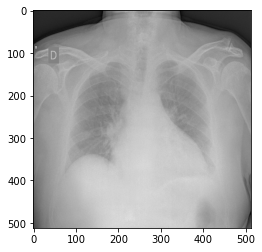

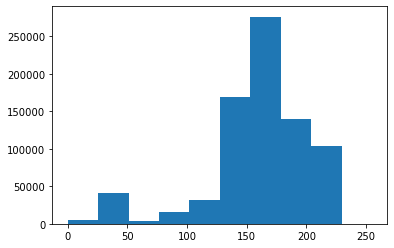

In [5]:
example = h5py.File(paths[0], 'r')
plt.imshow(example['img'][:])
plt.figure()
plt.hist(example['img'][:].flatten())
display(example['label'][:])
example.close()

In [6]:
trans = T.RandomApply(torch.nn.ModuleList([
                T.RandomAffine(
                    degrees = (10, 30),
                    translate = (0.2, 0.2),
                ),
                T.RandomHorizontalFlip(p=0.5)  
            ]),p = 0.8)

In [7]:
class SIIMData(Dataset):
    def __init__(self, paths, is_aug=False, img_size=config.image_size):
        super().__init__()
        self.paths = paths
        self.is_aug = is_aug
        self.img_size = img_size
        
    def __getitem__(self, idx):
        data = h5py.File(self.paths[idx], 'r')
        image = data['img'][:][:, :, 0]
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, self.img_size)
        image = image/255
        image = torch.tensor(image).view(self.img_size[0], self.img_size[1], 1)
        label = np.argmax(data['label'][:]).astype(int)
        if self.is_aug:
            return trans(image), torch.tensor(label)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.paths)

In [8]:
class Net(nn.Module):
    def __init__(self, out_size, model):
        super(Net, self).__init__()
        if model == 'dense':
            self.model = torchvision.models.densenet121(pretrained=True, **{'drop_rate' : 0.3})
            num_ftrs = self.model.classifier.in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(num_ftrs, out_size)
            )
            
        elif model == 'res':
            self.model = torchvision.models.wide_resnet101_2(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_ftrs, out_size)
            )
        elif model == 'inception':
            self.model = torchvision.models.inception_v3(pretrained=True, **{"aux_logits": False})
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_ftrs, out_size)
            )
        else:
            kwargs = { 
            'img_size': 488,
            'in_chans': 1,
            'num_classes': 4,
            'return_dense': False,
            'mix_token': False,
            'patch_size': 8,
            'drop_rate' : 0.3, 
        }
            self.model = volo_d1(**kwargs)
    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
class EfficientNetModel(nn.Module):
    """
    Model Class for EfficientNet Model
    """
    def __init__(self, num_classes=4, model_name=config.model_name, pretrained=True):
        super(EfficientNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class NFNetModel(nn.Module):
    """
    Model Class for EfficientNet Model
    """
    def __init__(self, num_classes=4, model_name=config.model_name, pretrained=True):
        super(NFNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.model.head.fc = nn.Linear(self.model.head.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
def roc_auc_compute_fn(y_preds, y_targets) -> float:
    return roc_auc_score(y_targets, y_preds, average='weighted', multi_class='ovo')

def one_hot(a):
    b = np.zeros((a.size, 4))
    b[np.arange(a.size),a] = 1
    return b

def one_hot_tensor(labels: torch.Tensor, num_classes: int, dtype: torch.dtype = torch.float, dim: int = 1) -> torch.Tensor:
    # if `dim` is bigger, add singleton dim at the end
    if labels.ndim < dim + 1:
        shape = list(labels.shape) + [1] * (dim + 1 - len(labels.shape))
        labels = torch.reshape(labels, shape)

    sh = list(labels.shape)

    if sh[dim] != 1:
        raise AssertionError("labels should have a channel with length equal to one.")

    sh[dim] = num_classes

    o = torch.zeros(size=sh, dtype=dtype, device=labels.device)
    labels = o.scatter_(dim=dim, index=labels.long(), value=1)

    return labels


In [12]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model, epoch = config.EPOCHS, agc=False):
        """
        Constructor for Trainer class
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.agc = agc
        
        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model = model.to(self.device)
        self.scaler = GradScaler()
        self.optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
        if config.loss == 'ce':
            self.loss = torch.nn.CrossEntropyLoss()
        elif config.loss == 'focal':
            self.loss = FocalLoss(**{"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'})
        elif config.loss == 'bce':
            self.loss = nn.BCEWithLogitsLoss()
        self.epoch = epoch
        self.best_auc = 0
        #self.tb = SummaryWriter(log_dir='./resruns')
        
    
    def train_one_cycle(self):
        """
        Runs one epoch of training, backpropagation and optimization
        """
        self.model.train()
        train_prog_bar = tqdm(self.train, total=len(self.train))

        all_train_labels = []
        all_train_preds = []
        
        running_loss = 0
        
        for xtrain, ytrain in train_prog_bar:
            xtrain = xtrain.to(self.device).float()
            ytrain = ytrain.to(self.device)
            xtrain = xtrain.permute(0, 3, 1, 2)
            with autocast():
                z = self.model(xtrain)
                if config.loss == 'bce':
                    train_loss = self.loss(z, one_hot_tensor(ytrain, 4))
                else:
                    train_loss = self.loss(z, ytrain)
                self.scaler.scale(train_loss).backward()
                if self.agc:
                    adaptive_clip_grad(self.model.parameters(), clip_factor=0.01, eps=1e-3, norm_type=2.0)
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
                running_loss += train_loss
                train_predictions = torch.argmax(z, 1).detach().cpu().numpy()
                train_labels = ytrain.detach().cpu().numpy()

                # Append current predictions and current labels to a list
                all_train_labels += [train_predictions]
                all_train_preds += [train_labels]

            # Show the current loss to the progress bar
            train_pbar_desc = f'loss: {train_loss.item():.4f}'
            train_prog_bar.set_description(desc=train_pbar_desc)
        
        # Now average the running loss over all batches and return
        train_running_loss = running_loss / len(self.train)
        print(f"Final Training Loss: {train_running_loss:.4f}")
        
        
        # Free up memory
        del all_train_labels, all_train_preds, train_predictions, train_labels, xtrain, ytrain, z
        gc.collect()
        torch.cuda.empty_cache()
        
        return train_running_loss

    def valid_one_cycle(self):
        """
        Runs one epoch of prediction
        """        
        self.model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        
        with torch.no_grad():
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0
            
            for xval, yval in valid_prog_bar:
                xval = xval.to(self.device).float()
                yval = yval.to(self.device)
                xval = xval.permute(0, 3, 1, 2)
                
                val_z = self.model(xval)
                
                if config.loss == 'bce':
                    val_loss = self.loss(val_z, one_hot_tensor(yval, 4))
                else:
                    val_loss = self.loss(val_z, yval)
                
                running_loss += val_loss.item()
                
                val_pred = torch.argmax(val_z, 1).detach().cpu().numpy()
                val_label = yval.detach().cpu().numpy()
                
                all_valid_labels += [val_label]
                all_valid_preds += [val_pred]
            
                # Show the current loss
                valid_pbar_desc = f"loss: {val_loss.item():.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            # Get the final loss
            final_loss_val = running_loss / len(self.valid)
            
            # Get Validation Accuracy
            all_valid_labels = np.concatenate(all_valid_labels)
            all_valid_preds = np.concatenate(all_valid_preds)
            acc = np.mean(all_valid_labels == all_valid_preds)
            auc = roc_auc_compute_fn(one_hot(all_valid_preds), one_hot(all_valid_labels))
            
            print(f"Final Validation Loss: {final_loss_val:.4f}")
            print(f"Final Validation Accuracy: {acc:.4f}")
            print(f"Final Validation AUC: {auc:.4f}")
            # Free up memory
            del all_valid_labels, all_valid_preds, val_label, val_pred, xval, yval, val_z
            gc.collect()
            torch.cuda.empty_cache()
            
        return (final_loss_val, self.model, acc, auc)
    
    def train_epoch(self):
        for i in range(self.epoch):
            train = self.train_one_cycle()
            #self.tb.add_scalar("Train Loss", train, i)
            test, model, acc, auc = self.valid_one_cycle()
            #self.tb.add_scalar("Val Acc", acc, epoch)
            #self.tb.add_scalar("Val Loss", auc, epoch)
            #self.tb.add_scalar("Val Loss", test, i)
            if auc > self.best_auc:
                self.best_auc = auc
                print(auc)
                #torch.save(self.model.state_dict(), './model_weights/resbest.pt')

In [13]:
training_set = SIIMData(train_path[:200], is_aug=True)
validation_set = SIIMData(test_path[:50])
train_loader = DataLoader(
    training_set,
    batch_size=config.TRAIN_BS,
    shuffle=True,
)

valid_loader = DataLoader(
    validation_set,
    batch_size=config.VALID_BS,
    shuffle=False
)
    

In [14]:
model = EfficientNetModel()
#model = Net(4, 'volo')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_aa-84b4657e.pth" to /home/ziqiao/.cache/torch/hub/checkpoints/tf_efficientnet_b3_aa-84b4657e.pth


In [15]:
train = Trainer(train_loader, valid_loader, model)

cuda:1


In [16]:
torch.cuda.empty_cache()
train.train_epoch()


Final Training Loss: 0.6480



Final Validation Loss: 0.6629
Final Validation Accuracy: 0.2400
Final Validation AUC: 0.5303
0.5303030303030303



Final Training Loss: 0.5712



Final Validation Loss: 0.6133
Final Validation Accuracy: 0.4400
Final Validation AUC: 0.4881



Final Training Loss: 0.5261



Final Validation Loss: 0.5281
Final Validation Accuracy: 0.5200
Final Validation AUC: 0.5000



Final Training Loss: 0.4884



Final Validation Loss: 0.5140
Final Validation Accuracy: 0.5200
Final Validation AUC: 0.5095



Final Training Loss: 0.4847



Final Validation Loss: 0.5244
Final Validation Accuracy: 0.5200
Final Validation AUC: 0.5000



Final Training Loss: 0.4764



Final Validation Loss: 0.5064
Final Validation Accuracy: 0.5000
Final Validation AUC: 0.4981



Final Training Loss: 0.4648



Final Validation Loss: 0.5400
Final Validation Accuracy: 0.5000
Final Validation AUC: 0.4981


KeyboardInterrupt: 